In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import HTML,IFrame

from scipy.io import wavfile
from scipy.ndimage import filters
from scipy import ndimage
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

# . . Section for general function definitions
def label(s1,s2,s3):
    plt.xlabel(s1,size=16); plt.ylabel(s2,size=16);plt.title(s3,size=20);

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

/Users/jeffreyshragge/opt/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/jeffreyshragge/opt/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


![title](data/TITLE.png)

### <h1><center>Module 11: Windows, Spectrograms and the Short-time Fourier Transform </center></h1>

The purpose of this section is for you to get experience in looking at how the spectral content can change in datasets represented by long time series.  So far we have looked at how the Fourier Transform can be applied to look at the spectral content. However, the Fourier Transform is a **global** operation that cannot distinguish how the frequency content varies within a signal.  Examples of the global nature are evident when one thinks about the following Fourier transform pair:

$$\delta(t-t_0) \leftrightarrow e^{i\omega t_0} \tag{1a}$$

and 

$$\cos (\omega_0 t) + i\sin(\omega_0 t) \leftrightarrow \delta(\omega-\omega_0) \tag{1b}$$

In equation 1a, a $\delta$-function spike at one moment in time affects everywhere in the frequency domain.  In equation 1b, a $\delta$-function spike at one frequency has an effect everywhere in the time domain.  Of course, we have looked at other less extreme examples where the effects are more restricted in the time and frequency domains.  For example, the Fourier transform of Gaussian function in the time domain is a Gaussian function in the frequency domain.

One of the underlying assumptions when applying a Fourier Transform is that the signals are **stationary**.  Playing a bit fast and loose with nomenclature, this means that if you have a signal $f(t)$ with Fourier Transform $\widehat{F}(\omega)$, then one assumes that the spectral components do not evolve over a longer time-scale $\tau$:

$$\frac{d \widehat{F}}{d\tau} = 0 \tag{1c}$$

However, we are all familiar with scenarios around us when transient phenomena is audible (e.g., a passing train) and we know that the frequency structure is changing as a function of time.  Does this mean that equation 1c does not hold?

$$\frac{d \widehat{F}}{d\tau} \neq 0 \tag{1d}??$$

How do we obtain more information about how the signal is evolving? Clearly, we need to think about moving from a **global** transform to one that is more **local**. While this might not make sense with the analytic Fourier Transform defined between $-\infty$ and $\infty$, one might feel intuitively that this can be done with the discrete Fourier Transform (DFT) because this operation is applied to a sequence of numbers without any requirement of $-\infty$ and $\infty$!

## Short-term thinking

One pathway forward is to break up a long time series of $N_t$ points into $N_w$ windows of length $N_t/N_w$ (with some prescribed degree of window overlap) and then apply $N_w$ Fourier Transforms (one also hears the term [short-time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)).  You can then concatenate the $N_w$ Fourier Transforms into a 2D representation of the signal: a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram).  

Completing these operations requires investigating a number of items: Spectrograms, Windowing and Gibbs Phenomena, and the Short-term Fourier Transform (STFT). We'll first look at some examples that complete this operation using the Scipy library [*signal.spectrogram*](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.spectrogram.html#scipy.signal.spectrogram) code.  We'll then dig a bit deeper to investigate the individual components making up this operation.

## Example 1 - Chirp Signals (i.e., Vibroseis)

One class of signals that are commonly used in many branches of the physical sciences is a [chirp signal](https://en.wikipedia.org/wiki/Chirp). An example in exploration seismology is the Vibroseis machine. Here's an example of one in action:

In [4]:
IFrame('https://www.youtube.com/embed/1tvNZYLyPqA', width=700, height=350)

### Creating a chirp signal

The general form of the chirp signal is given by:

$$x(t)=e^{i\phi (t)}, \tag{1} $$

where $\phi(t)$ is the phase function that is in general time dependent.  The [instantaneous frequency](https://en.wikipedia.org/wiki/Instantaneous_phase) is given by the time derivative:

$${\frac  {d\phi (t)}{dt}} = 2\pi f(t).\tag{2}$$

The interpretation of the signal in equation 2 is that this tells you at any given moment what the frequency content is of the signal.  Let's look at two different types of chirp signals:

**Linear**: $$f(t) = f_0+(f_1-f_0)\frac{t}{t_1} = f_0+kt, \quad t\in[0,t_1]. \tag{3}$$

where $k=(f_1-f_0)/t_1$ is slope of the linear change in frequency so that at time $t_0=0$ is $f_0$ and at some later reference time $t_1$ it is $f_1$. 

To get our phase function $\phi(t)$ we want to integrate both sides of the equation 2 for instantaneous frequency.  Integrating this yields:

$$
{\begin{aligned}\phi (t)&=\phi _{0}+2\pi \int _{0}^{t}f(\tau )\,d\tau \\&=\phi _{0}+2\pi \int _{0}^{t}(f_{0}+k\tau )\,d\tau \\&=\phi _{0}+2\pi \left(f_{0}t+{\frac  {k}{2}}t^{2}\right),\end{aligned}} \tag{4a}$$

where $\phi_0$ is the initial phase of the signal at $t=0$ (which we can set to zero most of the time). We observe a $t^2$ entering the phase so the frequency content of the signal is going to be time varying. Therefore, the chirp signal that we will be looking at is given by:

$$x(t) = e^{i\left( \phi _{0}+2\pi \left(f_{0}t+{\frac  {k}{2}}t^{2}\right)\right)} =
e^{i\phi _{0}} e^{i 2\pi f_{0}t} e^{i 2\pi(f_1-f_0) t^{2}/(2t_1) } \tag{4b}
$$

It is clear that if $f_1=f_0$ then the last term would equal to 1 and we would recover a sinusoidal signal.


**Hyperbolic**: $$f(t) = \frac{f_0 f_1 t_1}{(f_0-f_1)t+f_1t_1}. \tag{5}$$

I'll leave the integration of this to you!

Let's first plot the two functions as well as their Fourier Transforms.   The first is a **linear** chirp between $[f_0,f_1]=[10,200]$ over about 16 seconds of recording. The second is a **hyperbolic** chirp with the same frequency range. As expected, the FT panels show us the overall spectral content; however, they do not show us **how the frequencies are distributed throughout the time series**.  This is the information we are looking to obtain from a spectrogram.

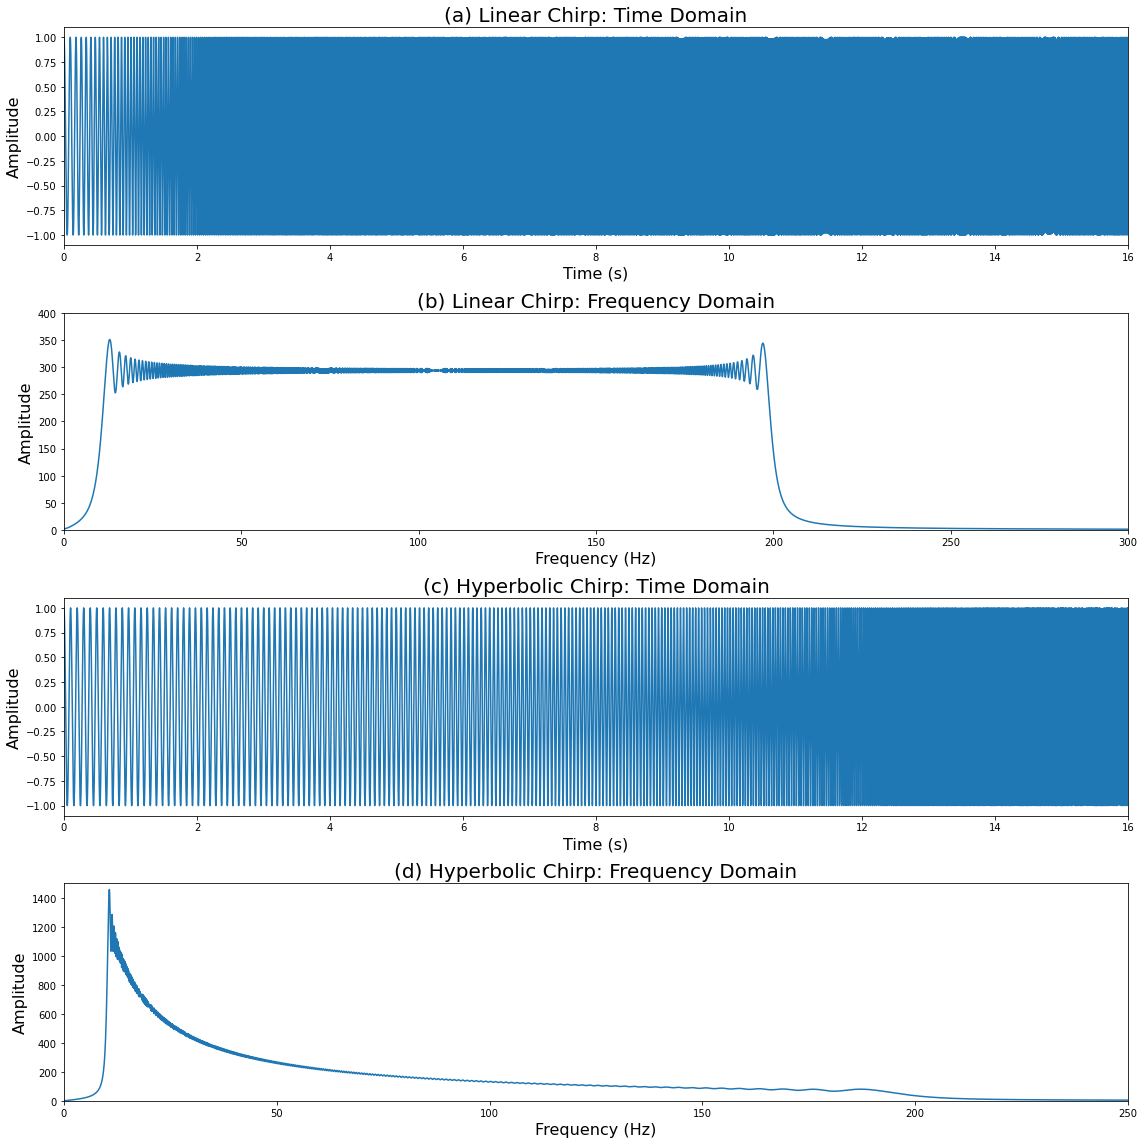

In [5]:
# . . Chirp signal
nt,dt=2048*16,0.0005
f0,f1=10,200
t1 = nt*dt
t=np.array(np.arange(0,nt))*dt

# . . Define Chirp signals
CC_LI = signal.chirp(t,f0=f0,t1=t1,f1=f1,method='linear')
CC_HY = signal.chirp(t,f0=f0,t1=t1,f1=f1,method='hyperbolic')

#CC_LI = np.sin(2*np.pi*(f0*t + (f1-f0)*np.sin(np.pi*t**2/t1**2)))

# . . FFTs and axes
CC_LI_FFT = np.fft.fft(CC_LI)
CC_HY_FFT = np.fft.fft(CC_HY)
freq = np.fft.fftfreq(nt,d=dt)

# . . Plot
plt.figure(figsize=(16, 16))

plt.subplot(411)
plt.plot(t,CC_LI)
label('Time (s)','Amplitude','(a) Linear Chirp: Time Domain')
plt.axis([0,16,-1.1,1.1])

plt.subplot(412)
plt.plot(freq[0:int(nt/2-1)],np.abs(CC_LI_FFT[0:int(nt/2-1)]))
label('Frequency (Hz)','Amplitude','(b) Linear Chirp: Frequency Domain')
plt.axis([0,300,0,400])

plt.subplot(413)
plt.plot(t,CC_HY)
label('Time (s)','Amplitude','(c) Hyperbolic Chirp: Time Domain')
plt.axis([0,16,-1.1,1.1])

plt.subplot(414)
plt.plot(freq[0:int(nt/2-1)],np.abs(CC_HY_FFT[0:int(nt/2-1)]))
label('Frequency (Hz)','Amplitude','(d) Hyperbolic Chirp: Frequency Domain')
plt.axis([0,250,0,1500])
plt.tight_layout(); plt.show()

**Figure 1. (a) Example of a linear chirp signal along with (b) the associated Fourier magnitude spectra. (c) Example of a hyperbolic chirp signal along with (d) the associated Fourier magnitude spectra.**

As expected, the FT panels show us the overall spectral content; however, they do not show us **how the frequencies are distributed throughout the time series**.  This is the information we are looking to obtain from a spectrogram.  

You can listen to the linear chirp sound here:

In [6]:
ipd.Audio(CC_LI, rate=2/dt) 

You can listen to the hyperbolic chirp sound here:

In [7]:
ipd.Audio(CC_HY, rate=2/dt) 

Now let's plot the spectrograms of these two functions, where the spectrograms on the right 

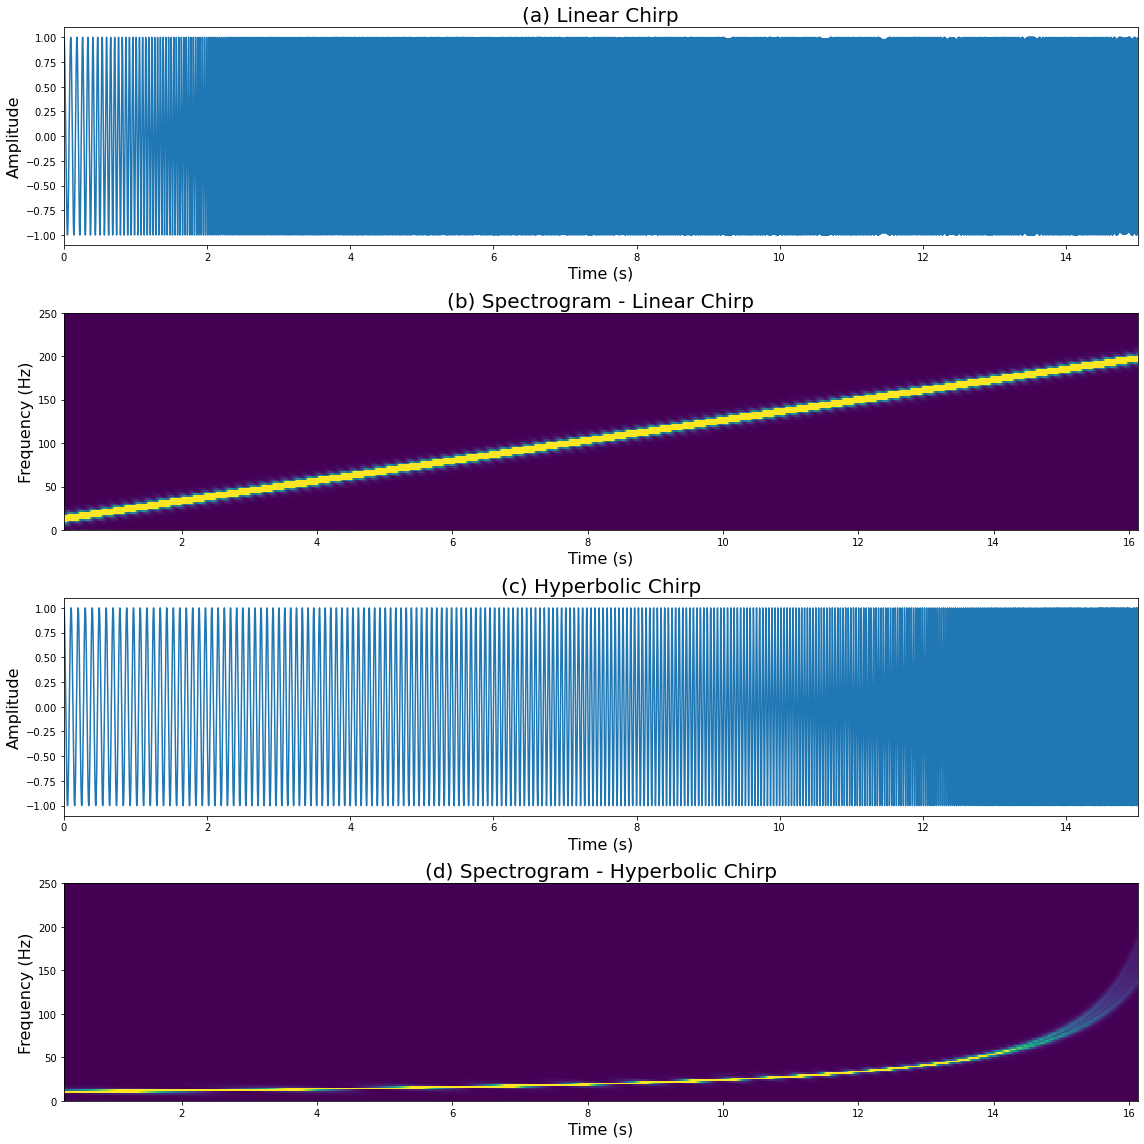

In [9]:
# . . Chirp signal
nt,dt=2048*16,0.0005
f0,f1=10,200
t=np.array(np.arange(0,nt))*dt

# . . Define Chirp signals
CC_LI = signal.chirp(t,f0=f0,t1=nt*dt,f1=f1,method='linear')
CC_HY = signal.chirp(t,f0=f0,t1=nt*dt,f1=f1,method='hyperbolic')

# . . Compute Spectrogram
f_CC_LI, t_CC_LI, S_CC_LI = signal.spectrogram(CC_LI,1/dt,nperseg=1024,noverlap=1020)
f_CC_HY, t_CC_HY, S_CC_HY = signal.spectrogram(CC_HY,1/dt,nperseg=1024,noverlap=1020)

# . . Plot signals and corresponding spectrograms
plt.figure(figsize=(16, 16))
plt.subplot(411)
plt.plot(t,CC_LI); 
label('Time (s)','Amplitude','(a) Linear Chirp')
plt.xlim(0,15)

plt.subplot(412)
plt.pcolormesh(t_CC_LI, f_CC_LI, S_CC_LI,cmap='viridis',vmin=0,vmax=0.01)
plt.ylim(0,1.25*f1)
label('Time (s)','Frequency (Hz)','(b) Spectrogram - Linear Chirp')

plt.subplot(413)
plt.plot(t,CC_HY); 
label('Time (s)','Amplitude','(c) Hyperbolic Chirp')
plt.xlim(0,15)

plt.subplot(414)
plt.pcolormesh(t_CC_HY, f_CC_HY, S_CC_HY,cmap='viridis',vmin=0,vmax=0.1)
plt.ylim(0,1.25*f1)
label('Time (s)','Frequency (Hz)','(d) Spectrogram - Hyperbolic Chirp')
plt.tight_layout(); plt.show()

**Figure 2. Demonstration of the utility of spectrograms. (a) Example of a linear chirp signal along with (b) the associated spectrogram. (c) Example of a hyperbolic chirp signal along with (d) the associated spectrogram.**

Let's now compute a nonlinear chirp where we have a modulation that changes as a function of $\sin(t): \sin \left[ 2\pi \left( f_0t+(f_1-f_0) \sin 2t \right) \right]$

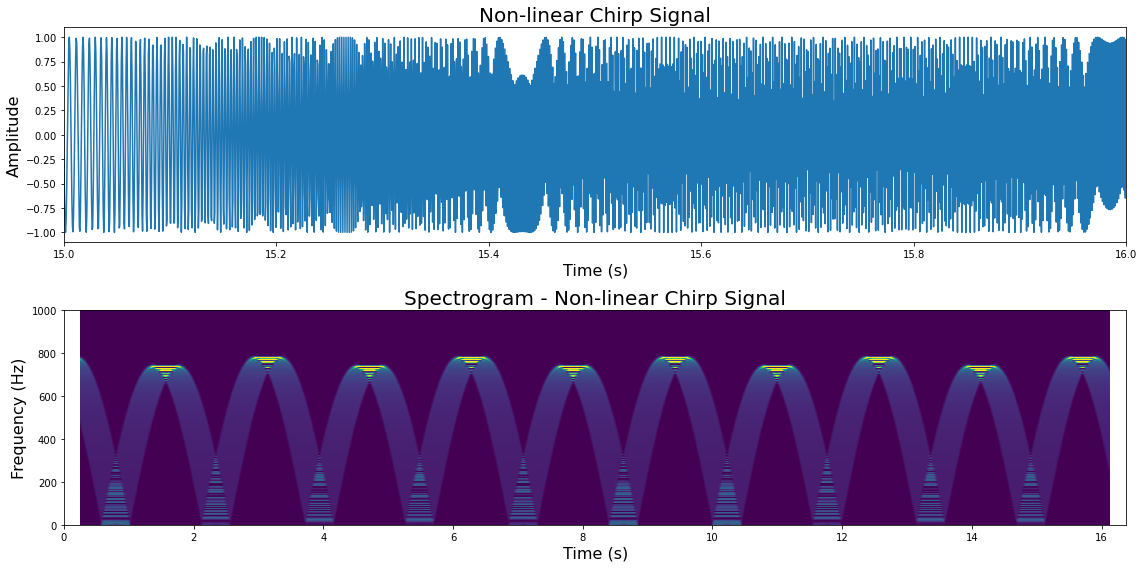

In [9]:
nt,dt=2048*16,0.0005
f0,f1=20,400
t=np.array(np.arange(0,nt))*dt

# . . Define Chirp signals
CC_NL = np.sin(2*np.pi*(f0*t +(f1-f0)*np.sin(2*t)))

# . . Compute Spectrogram
f_CC_NL, t_CC_NL, S_CC_NL = signal.spectrogram(CC_NL,1/dt,nperseg=1024,noverlap=1020)

# . . Plot signal and spectrogram
plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.plot(t,CC_NL); 
label('Time (s)','Amplitude','Non-linear Chirp Signal')
plt.xlim(15,16)

plt.subplot(212)
plt.pcolormesh(t_CC_NL, f_CC_NL, S_CC_NL,cmap='viridis',vmin=0,vmax=0.01)
plt.ylim(0,2.5*f1)
plt.xlim(0,nt*dt)
label('Time (s)','Frequency (Hz)','Spectrogram - Non-linear Chirp Signal')
plt.tight_layout(); plt.show()

**Figure 3. (a) Example of a non-linear chirp signal along with (b) the associated spectrogram.**

Let's now listen to this signal:

In [10]:
ipd.Audio(CC_NL, rate=2/dt) 

## Example 2 - Passing Train with Doppler Effect and Clickity Clacks

Let's next examine a the sound that a passing train makes.  We learned in freshman physics that, due to the Doppler effect, a train coming toward an observer will have a frequency spectrum that is shifted from the one heard from a receding train.  Listen to the following example to hear what happens at between 6-7s.

In [11]:
# . . Read in train noise
train  , srp = librosa.load('wav/Indian_Train_sounds.wav')
t = np.array(np.arange(0,len(train)))/srp
ipd.Audio(train, rate=srp) 

Let's now look at the plot of the time series as well as the spectrogram.  The latter was computed in blocks of 2048 time samples (i.e., the $nlen$ or window length parameter) with consecutive windows overlapping by 1024 samples (i.e., the $noverlap$ or number of overlap parameter). Note I chose powers of 2 were chosen to facilitate FFT computations.

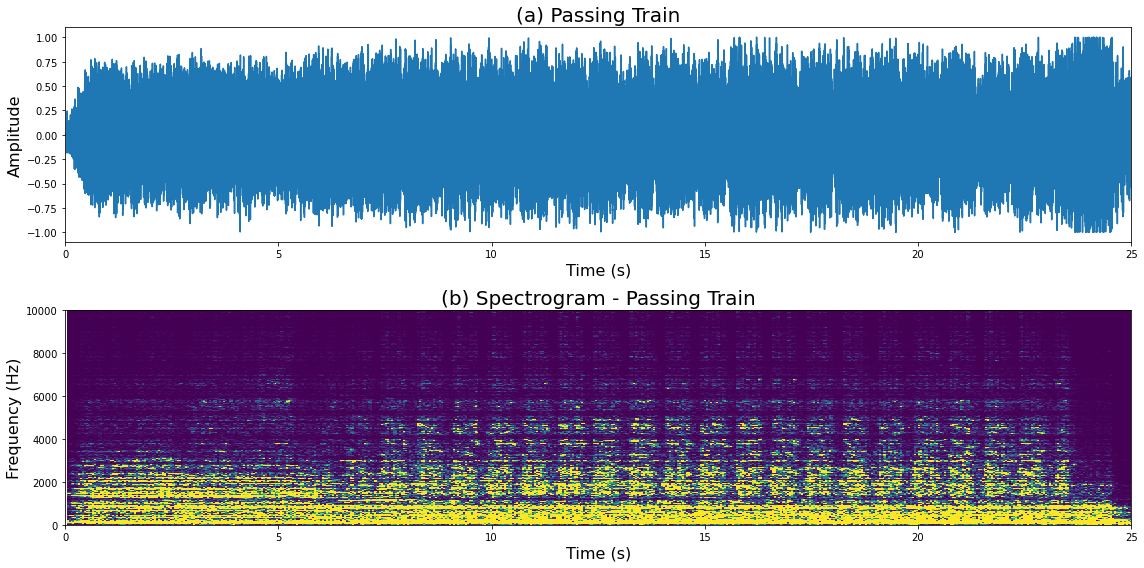

In [13]:
# . . Parameters for Spectrogram
nlen,noverlap=2048,1024  # . . Window length; how much overlap between neighbouring points

# . . Compute Spectrogram of the Passing Train
f_train, t_train, S_train = signal.spectrogram(train,srp,nperseg=nlen,noverlap=noverlap)

plt.figure(figsize=(16, 8));plt.subplot(2,1,1)
plt.plot(t,train); label('Time (s)','Amplitude','(a) Passing Train');plt.xlim(0,25)
plt.subplot(2,1,2)
plt.pcolormesh(t_train,f_train,S_train,cmap='viridis',vmin=0., vmax=0.000005)
plt.xlim(0,25); plt.ylim(0,10000);label('Time (s)','Frequency (Hz)','(b) Spectrogram - Passing Train')
plt.tight_layout(); plt.show()

**Figure 4. (a) Example of a recorded passing train along with (b) the associated spectrogram.**

Looking at the spectrogram, you can probably see that there is a bit of a down shift in frequency content from between 1-5 s to 5-7 s. You'll then notice the periodic "clickity-clack" of the train rolling over small (expansion) gaps in the tracks, which definitely causes a higher-frequency noise.  Again, this type of analysis would not be possible using a single global Fourier Transform.

## Example 3 - Tohoku Earthquake recorded in Germany

Let's now listen to the disasterous Tohoku earthquake as it was recorded at a station in Germany.  This signal represents the vertical motion at this station location.

In [12]:
# Cell 1: prepare data from Tohoku earthquake. 
#client = Client("BGR")
#t1 = UTCDateTime("2011-03-11T05:00:00.000")
#st = client.get_waveforms("GR","WET","","BHZ",t1,t1+6*60*60,attach_response = True)
#st.remove_response(output="VEL")
#st.detrend('linear')
#st.detrend('demean')
#np.savetxt('Tohoku.txt', st.traces[0].data, fmt='%f')

tohoku = np.loadtxt('data/Tohoku.txt', dtype=float)*1000 # Amplitudes in m/s
fs = 20 # . . Sampling rate in Hz
nt = len(tohoku)          # . . Number of Time Samples
t = np.arange(0,nt,1)/fs; # . . Time axis (for plotting)

# . . Play the earthquake
ipd.Audio(tohoku, rate=2048*fs) # load a NumPy array

You likely would have heard the first arrival (P-waves), as well as the second and third louder arrivals (S- and surface waves) coming in soon afterward.  If you listen again, can you detect some of the later arrivals as well?

Let's now look at the time series data as well as the spectrogram.  You'll see that the peaks of the spectrogram are well aligned with the visible arrivals in the plot of the time-series data.  You'll also notice that there are spikes in the spectrogram where you do not really see arriving waveforms: these are likely the more exotic P-wave phases that are weaker in amplitude ... but have higher frequency content!

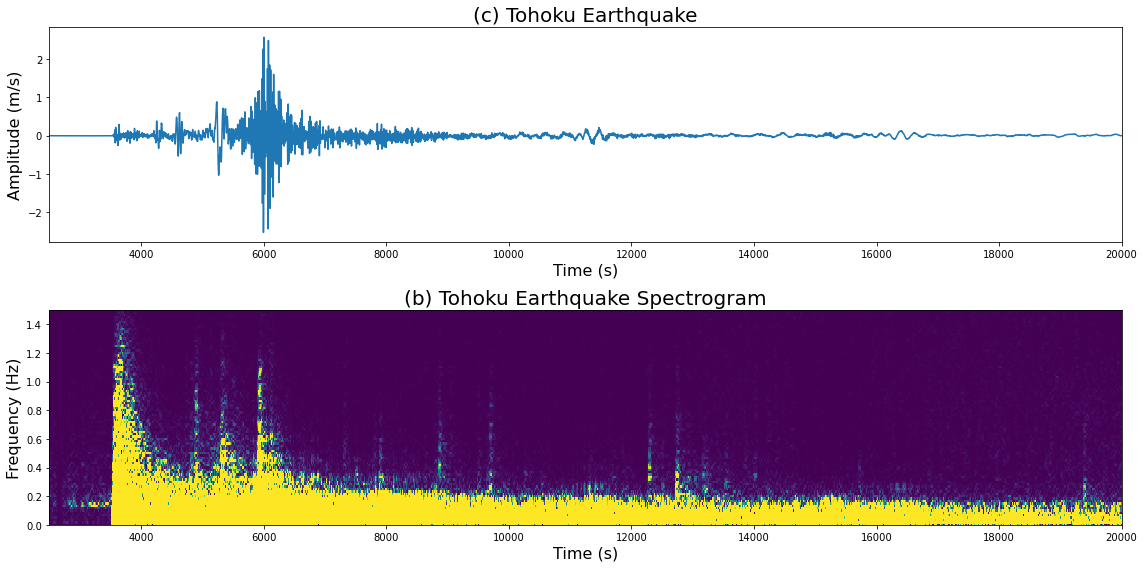

In [13]:
# . . Parameters for Spectrogram
nlen,noverlap=1200,1150  # . . Window length; how much overlap between neighbouring points

# . . Compute Spectrogram of Tohoku earthquake
f, tout, Sxx = signal.spectrogram(tohoku,fs,nperseg=nlen,noverlap=noverlap)

plt.figure(figsize=(16, 8))
plt.subplot(2,1,1)
plt.plot(t,tohoku); 
label('Time (s)','Amplitude (m/s)','(c) Tohoku Earthquake')
plt.xlim(2500,20000)

plt.subplot(2,1,2)
plt.pcolormesh(tout,f,Sxx,cmap='viridis',vmin=0., vmax=0.000005)
plt.xlim(2500,20000); plt.ylim(0,1.5)
label('Time (s)','Frequency (Hz)','(b) Tohoku Earthquake Spectrogram')
plt.tight_layout(); 
plt.show()

**Figure 5. (a) Example from the Tohoku earthquake with (b) the associated spectrogram.**

# Windowing 

The first major step in deciding how to construct a spectrogram is to decide on the windowing procedure that will be applied to diving the long time series into $N_w$ windows.  The first question to address is: does how you apply the windowing matter?  The answer in general is **yes**.  To illustrate why, look at the example below of a Gaussian waveform that is in the middle of a time series.  The frequency spectrum is located to the immediate right.  Note that the maximum frequency is about 35 Hz.  The second pair of panels (Figure 6c and 6d) illustrates what happens when you halve the time-series into two different windows and then apply the Fourier Transform. We see that the overall magnitude decreases and energy now appears at higher frequencies due to the rough truncation of the Gaussian function.  The third pair of panels (Figure 6e and 6f) shows what happens when the window is translated to be centered over the Gaussian.  We see that the spectrum returns to that of the first panel.  The final pair of panels (Figure 6g and 6h) shows the complement of the second panels with the altered frequency content.

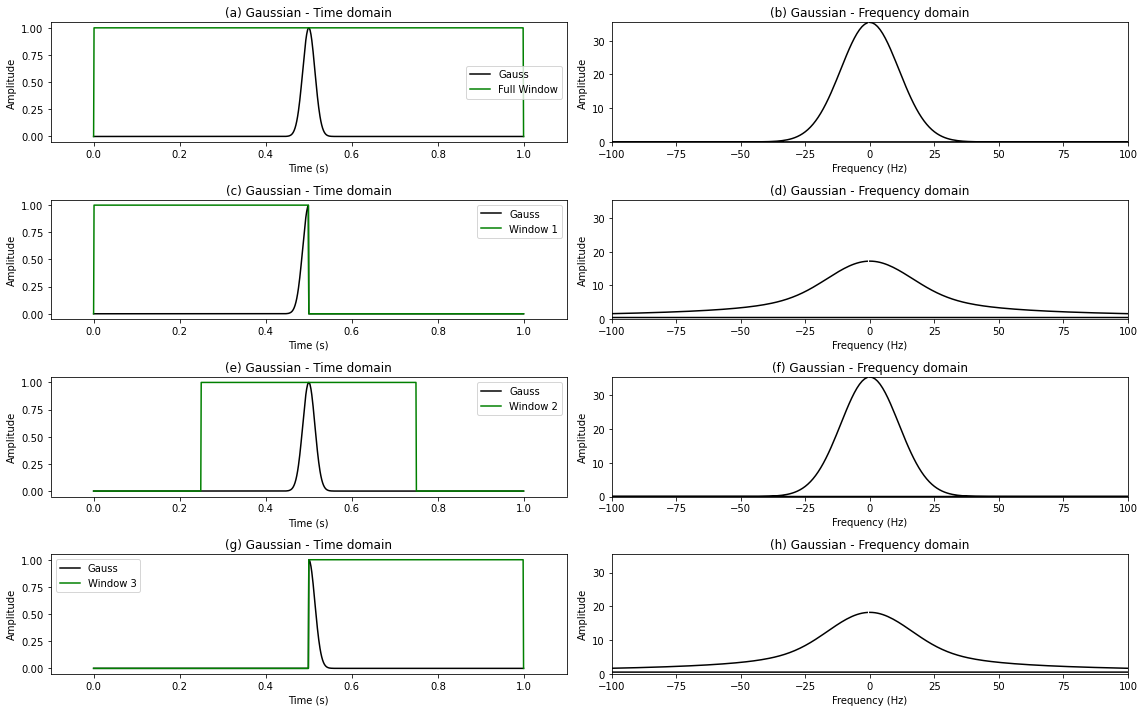

In [14]:
# . . Gaussian Example
nt,dt=1000,0.001
sig=0.0004
t = np.array(np.arange(0,nt*dt,dt))
g = np.exp(-(t-0.5)**2/(sig))
g1 = np.exp(-(t-0.5)**2/(sig)); g1[int(nt/2):]=0
g2 = np.exp(-(t-0.5)**2/(sig)); g2[0:int(nt/4)]=0;g2[int(3*nt/4):]=0; 
g3 = np.exp(-(t-0.5)**2/(sig)); g3[0:int(nt/2)]=0

# . . Implicity Windows
w = np.ones(nt);w[0]=0;w[nt-1]=0.
w1 =np.ones(nt);w1[int(nt/2):]=0.;w1[0]=0;w1[nt-1]=0.
w2 =np.zeros(nt);w2[int(nt/4):int(3*nt/4)]=1.;w2[0]=0;w2[nt-1]=0.
w3 =np.ones(nt);w3[:int(nt/2)]=0.;w3[0]=0;w3[nt-1]=0.

# . . FFT of Gauss
freq   = np.fft.fftfreq(nt,d=dt)
g_fft  = np.fft.fft(g)
g1_fft = np.fft.fft(g1)
g2_fft = np.fft.fft(g2)
g3_fft = np.fft.fft(g3)

plt.figure(figsize=(16, 10))
plt.subplot(421)
plt.plot(t,g,'k',t,w,'g')
plt.xlabel('Time (s)');plt.ylabel('Amplitude');plt.title('(a) Gaussian - Time domain')
plt.xlim(-0.1,1.1)
plt.legend(['Gauss','Full Window'])

plt.subplot(422)
plt.plot(freq,np.abs(g_fft),'k')
plt.xlabel('Frequency (Hz)');plt.ylabel('Amplitude');plt.title('(b) Gaussian - Frequency domain')
plt.xlim(-100,100);plt.ylim(0,np.max(np.abs(g_fft)))

plt.subplot(423)
plt.plot(t,g1,'k',t,w1,'g')
plt.xlabel('Time (s)');plt.ylabel('Amplitude');plt.title('(c) Gaussian - Time domain')
plt.xlim(-0.1,1.1)
plt.legend(['Gauss','Window 1'])

plt.subplot(424)
plt.plot(freq,np.abs(g1_fft),'k')
plt.xlabel('Frequency (Hz)');plt.ylabel('Amplitude');plt.title('(d) Gaussian - Frequency domain')
plt.xlim(-100,100);plt.ylim(0,np.max(np.abs(g_fft)))

plt.subplot(425)
plt.plot(t,g2,'k',t,w2,'g')
plt.xlabel('Time (s)');plt.ylabel('Amplitude');plt.title('(e) Gaussian - Time domain')
plt.xlim(-0.1,1.1)
plt.legend(['Gauss','Window 2'])

plt.subplot(426)
plt.plot(freq,np.abs(g2_fft),'k')
plt.xlabel('Frequency (Hz)');plt.ylabel('Amplitude');plt.title('(f) Gaussian - Frequency domain')
plt.xlim(-100,100);plt.ylim(0,np.max(np.abs(g_fft)))

plt.subplot(427)
plt.plot(t,g3,'k',t,w3,'g')
plt.xlabel('Time (s)');plt.ylabel('Amplitude');plt.title('(g) Gaussian - Time domain')
plt.xlim(-0.1,1.1)
plt.legend(['Gauss','Window 3'])

plt.subplot(428)
plt.plot(freq,np.abs(g3_fft),'k')
plt.xlabel('Frequency (Hz)');plt.ylabel('Amplitude');plt.title('(h) Gaussian - Frequency domain')
plt.xlim(-100,100);plt.ylim(0,np.max(np.abs(g_fft)))
plt.tight_layout(); plt.show()

**Figure 6. Illustrating how the location of the slide window can affect the resulting frequency calculation forr a Gaussian signal. (a) Gaussian signal and full selection window that results in the Fourier magnitude spectrum in (b). (c) Gaussian signal trucated by left-half window length that results in the Fourier magnitude spectrum in (d). (e) Gaussian signal with centered window that results in the Fourier magnitude spectrum in (f). (g) Gaussian signal trucated by right-half window length that results in the Fourier magnitude spectrum in (h).**

Let's now look at a spectrogram in Figure 7a of the 1000-point time Gaussian that is computed on windows of length 400, and then translated by 1 sample.  Thus, we expect a total of 600 different frequency distributions.  The plot below shows the results of this where the time coordinate is the center of the sliding window.  We again see that the frequency distribution appears to change.  Let's recompute the spectrogram in Figure 7b using smallering windows of 200 samples (and then shifting the output by one sample).  Again, we see the frequency content varying with lag - but in a different way than the example to the left.  We also see that by halving the number of samples, the frequency resolution also has dropped by a factor of two. 

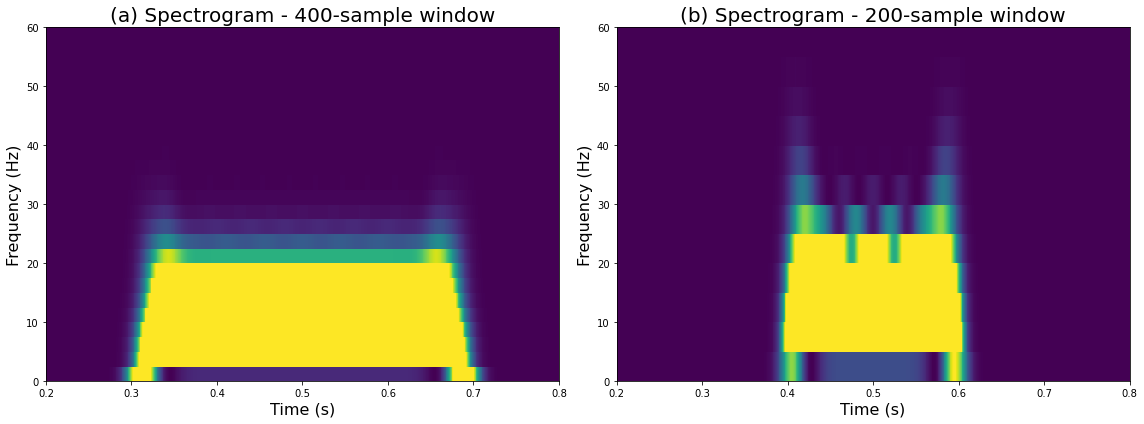

In [21]:
plt.figure(figsize=(16, 6))
nperseg,noverlap=400,399
f_Gauss,t_Gauss,S_Gauss = signal.spectrogram(g,1/dt,nperseg=nperseg,noverlap=noverlap)
plt.subplot(121)
plt.pcolormesh(t_Gauss,f_Gauss,S_Gauss,cmap='viridis',vmin=0., vmax=0.0005)
plt.xlim(0.2,0.8); plt.ylim(0,60)
label('Time (s)','Frequency (Hz)','(a) Spectrogram - 400-sample window')

nperseg,noverlap=200,199
f_Gauss,t_Gauss,S_Gauss = signal.spectrogram(g,1/dt,nperseg=nperseg,noverlap=noverlap)
plt.subplot(122)
plt.pcolormesh(t_Gauss,f_Gauss,S_Gauss,cmap='viridis',vmin=0., vmax=0.0005)
plt.xlim(0.2,0.8); plt.ylim(0,60)
label('Time (s)','Frequency (Hz)','(b) Spectrogram - 200-sample window')
plt.tight_layout(); plt.show()

**Figure 7. Example of how spectrogram can change depending on window length. (a) $N=400$ window length. (b) $N=200$ window length.  Note that the longer window length gives finer resolution in frequency.**

A second consideration when applying of a windowing procedure is that if one applies a windowing function that has sharp corners (e.g., a boxcar $\Pi_n$ function) is that this can impart a significant ringing of the resulting spectrum (which is an example of [Gibbs phenomena](https://en.wikipedia.org/wiki/Gibbs_phenomenon)).  To illustrate this, let's look at an example where we have fairly broad waveform (shown in blue in upper left) that has a fairly low frequency distribution (upper right). 

Let's now apply a box-car windowing function (shown in black in the lower right panel) that has a *sinc-function* frequency-domain representation. If we look at the resulting waveform in the time domain (shown in red in lower right panel), we see that the truncation has caused the waveform to become very ringy.  This is because **the multiplication of the two waveforms in the time domain (e.g., the red curve) is equivalent the convolution of the blue and black curves in the frequency domain (red curve)**.

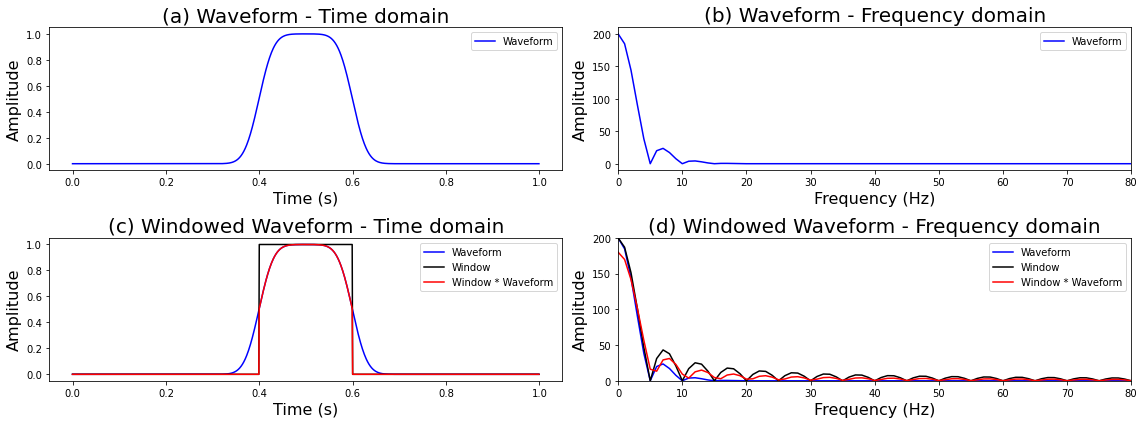

In [15]:
t = np.array(np.arange(0,nt*dt,dt))
boxcar = np.zeros(nt); 
boxcar[int(0.4*nt):int(0.6*nt)]=1.

boxcar_gauss_smooth = filters.gaussian_filter1d(boxcar,25)
freq = np.fft.fftfreq(nt,d=dt)

plt.figure(figsize=(16, 6))
plt.subplot(221)
plt.plot(t,boxcar_gauss_smooth,'b')
label('Time (s)','Amplitude','(a) Waveform - Time domain')
plt.legend(['Waveform'])

plt.subplot(222)
plt.plot(freq[:int(nt/2)],np.abs(np.fft.fft(boxcar_gauss_smooth)[:int(nt/2)]),'b')
plt.xlim(0,80)
label('Frequency (Hz)','Amplitude','(b) Waveform - Frequency domain')
plt.legend(['Waveform'])

# . . Cut boxcar
window = np.zeros(nt);
window[int(0.4*nt):int(0.6*nt)]=1.

plt.subplot(223)
plt.plot(t,boxcar_gauss_smooth,'b',t,window,'k',t,boxcar_gauss_smooth*window,'r',)
label('Time (s)','Amplitude','(c) Windowed Waveform - Time domain')
plt.legend(['Waveform','Window','Window * Waveform'])

plt.subplot(224)
plt.plot(freq[:int(nt/2)],np.abs(np.fft.fft(boxcar_gauss_smooth)[:int(nt/2)]),'b', \
         freq[:int(nt/2)],np.abs(np.fft.fft(window)[:int(nt/2)]),'k', \
         freq[:int(nt/2)],np.abs(np.fft.fft(window*boxcar_gauss_smooth)[:int(nt/2)]),'r')
plt.xlim(0,80);plt.ylim(0,200)
label('Frequency (Hz)','Amplitude','(d) Windowed Waveform - Frequency domain')
plt.legend(['Waveform','Window','Window * Waveform'])

plt.tight_layout(); plt.show()

**Figure 8. Example showing the Fourier-domain consequences of windowing. (a) Original waveform along with (b) the associated Fourier magnitude spectrum. (c) Windowed signal from (a) that results in (d) Gibb's effects in the Fourier magnitude spectrum.** 

# Playing with Smart Windowing Functions

There are many different windows types available for use in window functions.  In the plot below I investigate a number of them that are available in the [*scipy.signal* toolbox](https://docs.scipy.org/doc/scipy-0.19.1/reference/signal.html): (1) Blackman-Harris; (2) Chebeshev; (3) Hamming; (4) Gaussian; (5) Hann; (6) Kaiser; (7) Slepian; and (8) Tukey.  Let's look at what the windows look like and what the corresponding frequency spectra are!

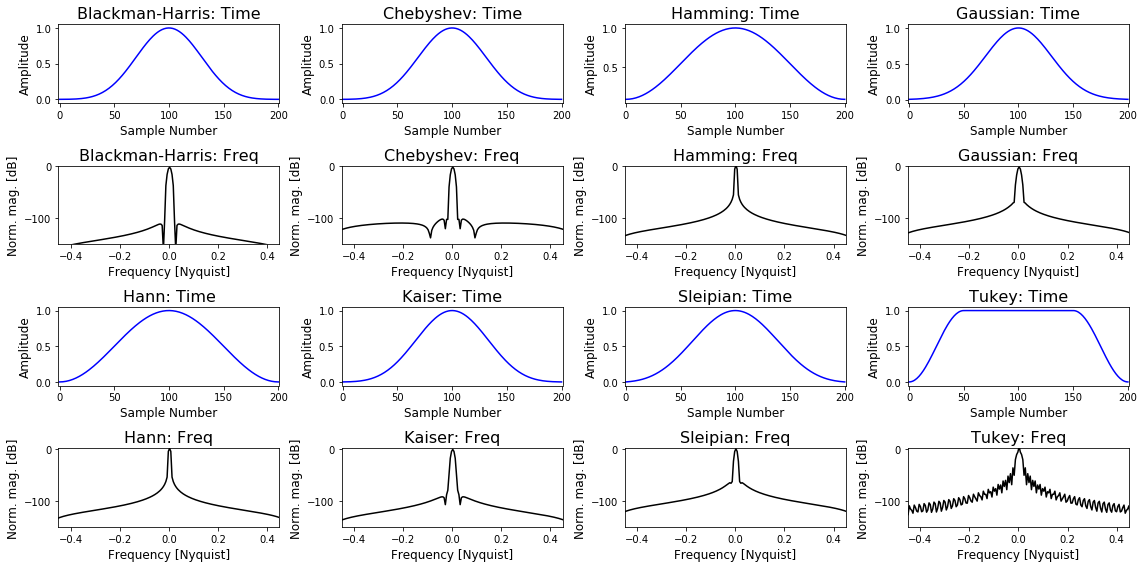

In [16]:
# . . Examples of different windows
nt=100

def plot_window(window,panel,s):
    plt.subplot(4,4,panel)
    plt.plot(np.linspace(0,len(window),len(window)),window,'b');
    plt.xlabel('Sample Number',size=12);plt.ylabel('Amplitude',size=12);plt.title(s,size=16)
    plt.xlim(-1,len(window)+1)
    
def plot_winfft(window,panel,s):
    plt.subplot(4,4,panel)
    plt.plot(np.linspace(-0.5,0.5,len(window)),-39+20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(window/abs(window).max())))),'k')
    plt.xlabel('Frequency [Nyquist]',size=12);plt.ylabel('Norm. mag. [dB]',size=12);plt.title(s,size=16)
    plt.xlim(-0.45,0.45); plt.ylim(-150,1)
    
nt=200;

plt.figure(figsize=(16,8))
plot_window(signal.blackmanharris(nt),1,'Blackman-Harris: Time')
plot_winfft(signal.blackmanharris(nt),5,'Blackman-Harris: Freq')
plot_window(signal.chebwin(nt,at=100),2,'Chebyshev: Time')
plot_winfft(signal.chebwin(nt,at=100),6,'Chebyshev: Freq')
plot_window(signal.hamming(nt),3,'Hamming: Time')
plot_winfft(signal.hamming(nt),7,'Hamming: Freq')
plot_window(signal.gaussian(nt, std=30),4,'Gaussian: Time')
plot_winfft(signal.gaussian(nt, std=30),8,'Gaussian: Freq')
plot_window(signal.hann(nt),9,'Hann: Time')
plot_winfft(signal.hann(nt),13,'Hann: Freq')
plot_window(signal.kaiser(nt, beta=10),10,'Kaiser: Time')
plot_winfft(signal.kaiser(nt, beta=10),14,'Kaiser: Freq')
plot_window(signal.slepian(nt, width=0.05),11,'Sleipian: Time')
plot_winfft(signal.slepian(nt, width=0.05),15,'Sleipian: Freq')
plot_window(signal.tukey(nt),12,'Tukey: Time')
plot_winfft(signal.tukey(nt),16,'Tukey: Freq')

plt.tight_layout(); plt.show()

**Figure 9. Illustration of eight differernt windowing functions along with their associated Fourier magnitude spectra (in dB down).**

In each of the frequency-domain plots the horizontal variables run from $[-0.45f_{max},0.45f_{max}]$, and the vertical axis is in normalized magnitude (dB), which is a logarithmic scale.  Thus, each window is doing very well in reducing any of the Gibbs ringing effect. Even by slightly varying the shape of the window operator, one can cause a signifant change in the resulting spectrum. A lot of electical engineering time has been spent designing these operators!

## Short-time Fourier Transform (SFTF)

Evidently, spectrograms are a powerful tool for investigating the **frequency structure** of signals. However, it would also be nice to be able to perform signal processing tasks on these types of functions in the frequency domain, and then transform the results back to the time domain for use in other operations.  To do this one can use the short-time Fourier Transform.  

### Example of a Noisy FM broadcast 

Your FM radio broadcasts signals using the concept the [frequency modulation](https://en.wikipedia.org/wiki/Frequency_modulation) as a way of carrying information, which is achieved by encoding of information in a carrier wave by varying the instantaneous frequency of the wave. 

$$ y(t)=A_{c}\cos \left(2\pi f_{c}t+{\frac {A_{m}}{f_{m}}}\sin \left(2\pi f_{m}t\right)\right).$$

Here, $A_c$ is the overall amplitude, $f_c$ is the carrier frequency, $A_m$ is the amplitude of the modulated signal, and $f_m$ is the modulation frequency.

Let's create a FM signal with $A_c = 2\sqrt{2}$, $f_c=1000$ Hz, $A_m=500$ Hz, and $f_m=1 $ Hz and apply a Tukey window to handle any edge effects. Let's first listen to the clean signal. 

In [16]:
fs = 10e3
N = 1e5
amp = 2. * np.sqrt(2.)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500.*np.cos(2*np.pi*1.0*time)
carrier = amp * np.sin(2.*np.pi*1.e3*time + mod)*signal.tukey(int(N),alpha=0.1)
noise = np.random.normal(scale=np.sqrt(noise_power),size=time.shape)
noise *= 0.25*np.exp(-time/100.)*signal.tukey(int(N),alpha=0.1)
x = carrier + noise

ipd.Audio(carrier, rate=fs) 

Now let's corrupt this signal with Gaussian noise such that it is strongly audible when listening to the FM signal.  

In [17]:
ipd.Audio(x, rate=fs) 

Now let's visualize the signal and the noisy signal. Here's a plot of the two signals overtop of each other.  You'll notice that I have applied a Tukey window to the first and last 10% to order to have a smooth tapering into the ends (which is a requirement for stability of the STFT).

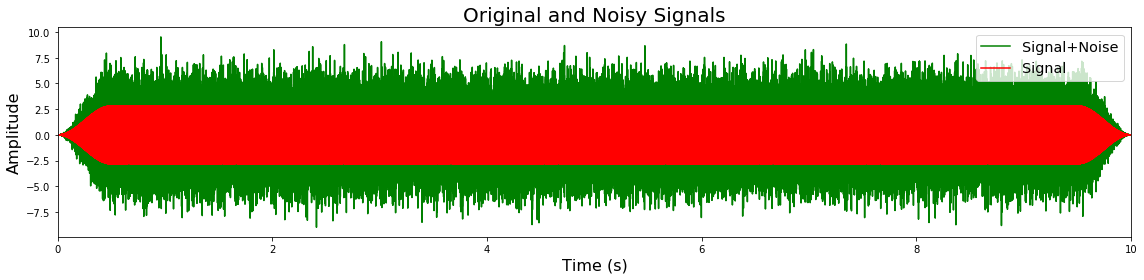

In [31]:
plt.figure(figsize=(16,4))

plt.plot(time,x,'g',time,carrier,'r')
plt.xlim(0,10)
label('Time (s)','Amplitude','Original and Noisy Signals')
plt.legend(['Signal+Noise','Signal'],fontsize = 'x-large')
plt.tight_layout(); plt.show()

**Figure 11. Illustration of the carrier signal (orange) along with additive noise (green).**

Let's now apply the STFT to the noisy signal using sliding window of 512 samples with an overlap of 256 samples.  The top panel shows the output of the SFTF with the signal clearly visible as the yellow modulating line.  However, one can still see the contribution of the random Gaussian noise in the background.  It's our goal to get rid of this!

To help eliminate the "salt-and-pepper" background, we're going to apply a **thresholding** operation.  Essentially, this scans the entire file and sets to zero any absolute value (recall this is a complex-valued function) that is lower than X% of the maximum value.  For the example here, I decided that the threshold value will be 20%.  

The middle panel shows the result of thresholdeding the STFT noisy signal.  We see that most of the background Gaussian noise has disappeared, leaving on the desired modulating signal. The lower panel shows the difference between the top and middle panels - effectively showing the **residual estimated noise**.

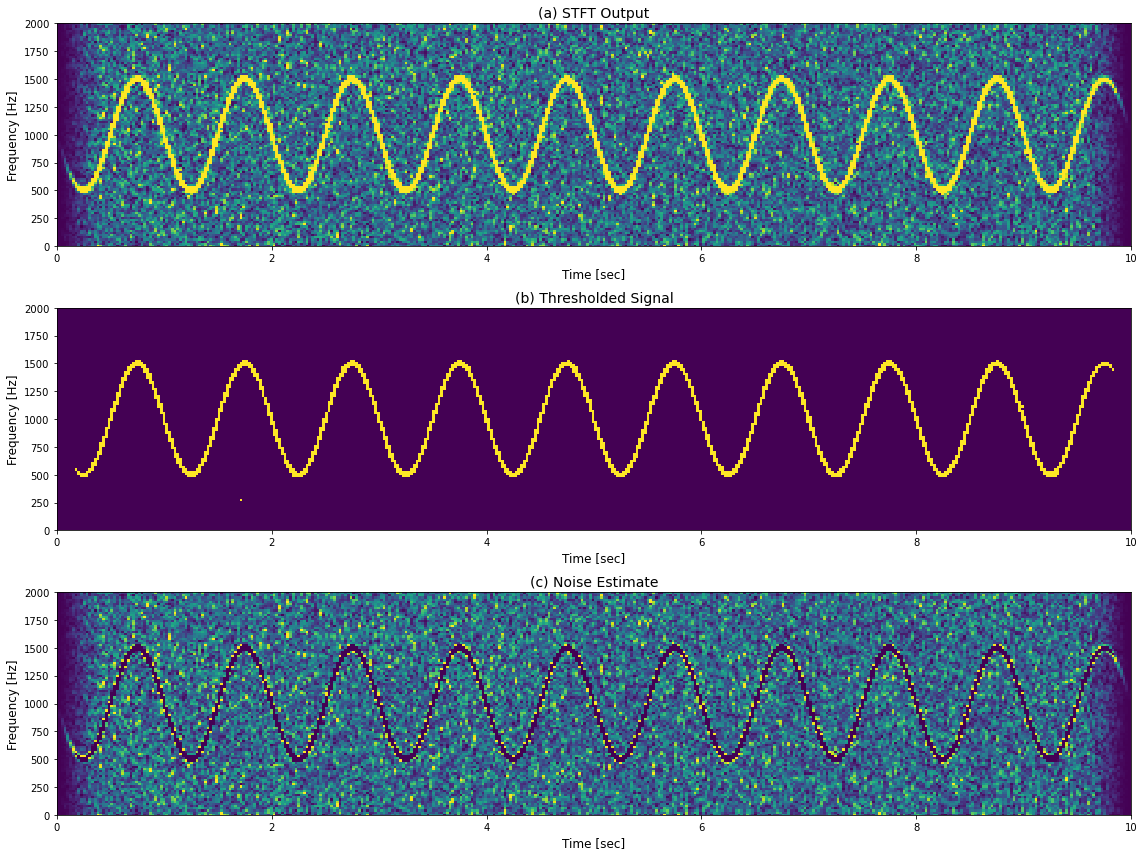

In [19]:
# . . Apply the STFT to the signal 
f, t, Zxx = signal.stft(x, fs, nperseg=512,noverlap=256)

# . . Threshold the signal
Zxx_thresh = np.where(np.abs(Zxx) >= np.max(np.abs(Zxx))/5, Zxx, 0)

plt.figure(figsize=(16,12))
plt.subplot(311)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=0.15*np.max(np.abs(Zxx)),cmap='viridis')
plt.title('(a) STFT Output',size=14)
plt.ylabel('Frequency [Hz]',size=12)
plt.xlabel('Time [sec]',size=12)
plt.xlim(0,10);plt.ylim(0,2000)

plt.subplot(312)
plt.pcolormesh(t, f, np.abs(Zxx_thresh), vmin=0, vmax=0.15*np.max(np.abs(Zxx)),cmap='viridis')
plt.title('(b) Thresholded Signal',size=14)
plt.ylabel('Frequency [Hz]',size=12)
plt.xlabel('Time [sec]',size=12)
plt.xlim(0,10);plt.ylim(0,2000)

plt.subplot(313)
plt.pcolormesh(t, f, np.abs(Zxx_thresh-Zxx), vmin=0, vmax=0.15*np.max(np.abs(Zxx)),cmap='viridis')
plt.title('(c) Noise Estimate',size=14)
plt.ylabel('Frequency [Hz]',size=12)
plt.xlabel('Time [sec]',size=12)
plt.xlim(0,10);plt.ylim(0,2000)

plt.tight_layout(); plt.show()

**Figure 12. Illustration of thresholding as a denoising technique. (a) STFT output of the signal. (b) Result from (a) after thresholding. (c) Estimate from the subtracted thresholded noise.**


Let's now reconstruct the signal using the **inverse short-time Fourier Transform (ISTFT)**.  This can be achieved with the *signal.istft* function (that also requires passing the window length in samples and the overlap).

Figure 13 shows a zoom in on a section of the signals between $t=4.3$s and $t=4.7$s. Figure 13a shows the **original signal**, which demonstrably is showing frequency modulation behaviour. Figure 13b shows the **noise-corrupted signal** as described above. Figure 13c shows the **reconstructed signal** after applying thresholding and the ISTFT.  We see that the general shape is much closer to the expected result; however, there are longer wavelength variations (i.e., with a 20-40 Hz period) that are indicating that we haven't done a perfect jb.  Finally, Figure 13d shows the **residual estimated noise** that is the difference between the middle two panels.  The noise appears as quite high frequency, which is consistent with the frequency spread of noise that we saw in the ISTFT panels.

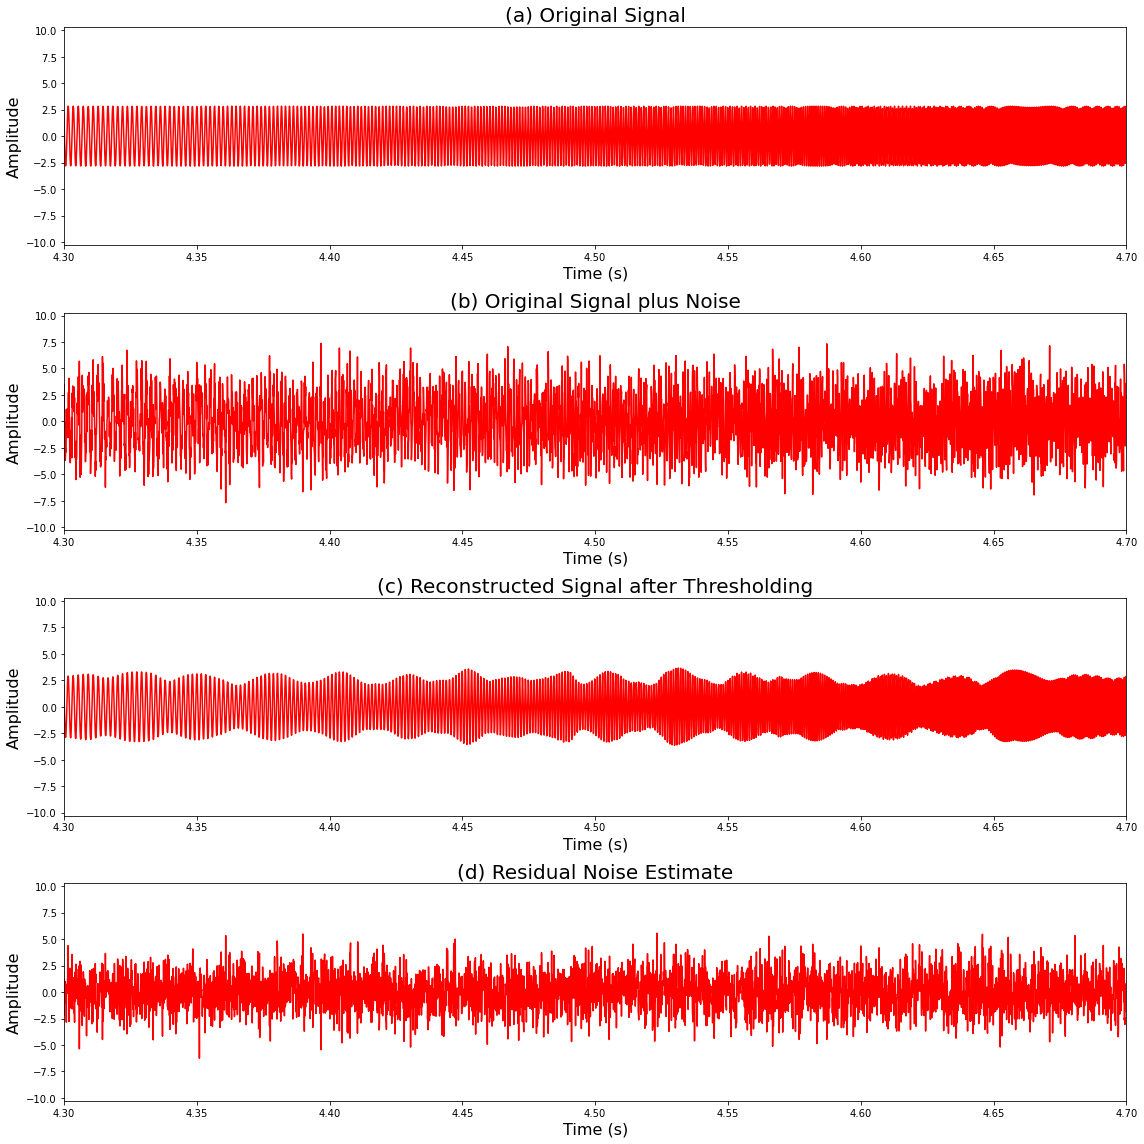

In [20]:
# . . Apply ISTFT
tt, xrec = signal.istft(Zxx_thresh, fs, nperseg=512,noverlap=256)

## . . Plotting
tmin,tmax=4.3,4.7 # plot range
plt.figure(figsize=(16,16))
plt.subplot(411)
plt.plot(time,carrier,'r')
plt.xlim(tmin,tmax);plt.ylim(-np.max(np.abs(x)),np.max(np.abs(x)))
label('Time (s)','Amplitude','(a) Original Signal')

plt.subplot(412)
plt.plot(time,x,'r')
plt.xlim(tmin,tmax);plt.ylim(-np.max(np.abs(x)),np.max(np.abs(x)))
label('Time (s)','Amplitude','(b) Original Signal plus Noise')

plt.subplot(413)
plt.plot(tt,xrec,'r')
plt.xlim(tmin,tmax);plt.ylim(-np.max(np.abs(x)),np.max(np.abs(x)))
label('Time (s)','Amplitude','(c) Reconstructed Signal after Thresholding')

plt.subplot(414)
tt, xnse = signal.istft(Zxx_thresh-Zxx, fs, nperseg=512)
plt.plot(tt,xnse,'r')
plt.xlim(tmin,tmax);plt.ylim(-np.max(np.abs(x)),np.max(np.abs(x)))
label('Time (s)','Amplitude','(d) Residual Noise Estimate')
plt.tight_layout(); plt.show()

**Figure 13. Looking at the denoising process in the time domain. (a) Original signal. (b) Original signal plus noise. (c) Estimated reconstructed signal after thresholding and reconstrution. (d) Noise estimate.**

Let's now listen again to the original signal:

In [21]:
ncut=4000
ipd.Audio(carrier[ncut:len(x)-ncut], rate=fs) 

as well as the noisy signal:

In [22]:
ipd.Audio(x[ncut:len(x)-ncut], rate=fs) 

Now's let's listen to the reconstructed signal recovered through the STFT-thresholding-ISTFT process:

In [23]:
ipd.Audio(xrec[ncut:len(x)-ncut], rate=fs) 

This now seems to be pretty noise free (even if the low frequencies aren't perfectly reconstructed!)  Finally, let's listed to the residual noise estimate to hear if any of our signal is present. 

In [24]:
ipd.Audio(xrec[ncut:len(x)-ncut]-x[ncut:len(x)-ncut], rate=fs) 

Overall, the thresholding operation seems to have done a pretty good job ... and there isn't much signal in the residual (which is what we want)!